<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/02_Prophet.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prophet Model

Prophet is a model developed by Meta (Facebook), used by Meta itself to make reliable forecasts for planning and goal-setting. It has been released by Meta as open source, allowing for free usage and customization.

Prophet allows for the estimation of trends and seasonalities on a monthly, weekly, and daily basis.

Prophet is an additive regression model based on three main components:

*   **Trend**: A segmented linear or logistic growth trend. Prophet automatically detects changes in the trend by selecting changepoints from the data.
*   **Annual and weekly seasonal components**: Modeled using Fourier series with periods P=365.25 and P=7.
*   **List of holidays/significant days**: User can specify holidays (Christmas, New Year, Easter, etc.) or relevant days (e.g., Black Friday)

Prophet forecast is represented in the following way:

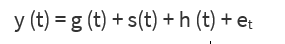

Where g(t) is the trend component, s(t) the seasonality, h(t) the holidays effect and e(t) epresents random variations assumed to be normally distributed (Gaussian). Each function (g, s, h) has its own weight and is characterized by a set of parameters that need to be optimized to improve the model's fit to the data.

The weight of each component needs to be tuned and its related to an hyperparameter:

*   **Changepoint Prior Scale**: It determines the flexibility of the trend. The higher the value, the more flexible the trend. This is a very important parameter to tune because if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term, but if its too high the trend will overfit.
*   **Seasonality Prior Scale**: This parameter controls the flexibility of the seasonality. Similarly to the changepoint prior scale, a large value allows the seasonality to fit large fluctuations, while a small value shrinks the magnitude of the seasonality.
*   **Seasonality Mode**: By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. However, in some cases the seasonality is not a constant additive factor as assumed by Prophet, but rather it grows with the trend. For this cases the seasonality must be set to 'multiplicative'
*   **Seasonality Fourier Order**: Seasonalities (for example weekly or yearly seasonalities) are estimated using a partial Fourier sum. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting
*   **Holidays Prior Scale**: This controls flexibility to fit holiday effects. As Changepoint Prior Scale and Seasonality Prior Scale, a large value allows to fit large fluctuations, a small value shrinks the magnitude of this effect.


Finally, Prophet can be used for univariate models only. This means that  Prophet only makes forecasts with only one dependent variable. If you’d want to adapt to multivariate forecasts, you’d need to train a Prophet for each dependent variable separately.





#### 1 - Importing Data

Data: Daily number of shipments made by a courier service

Period of Record: June 2021 - February 2024

Number of observations: 1004
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYYY-MM-DD format
2.   numero_spedizioni - number of shipments

Source: https://github.com/ric4234/AI-Fridays/blob/main/Dataset/dataset_spedizioni.csv

Raw Data Source: https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# URL of the dataset on GitHub
url = "https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv"
# Load the dataset into a pandas DataFrame
df = pd.read_csv(url)
# Convert the 'data' column to datetime format
df['data'] = pd.to_datetime(df['data'])

# Display the informations of the dataframe
print(df.info())
# Display the first few rows of the DataFrame to verify it's loaded correctly
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               1004 non-null   datetime64[ns]
 1   numero_spedizioni  1004 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.8 KB
None
        data  numero_spedizioni
0 2021-06-01             358890
1 2021-06-02               1192
2 2021-06-03             424296
3 2021-06-04             346785
4 2021-06-05                 10


#### 2 - Plotting Data

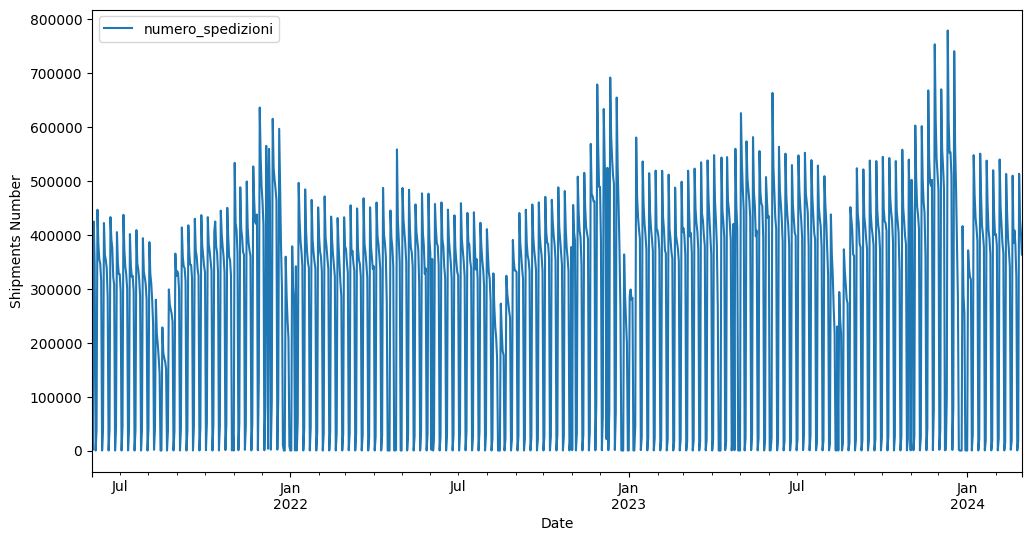

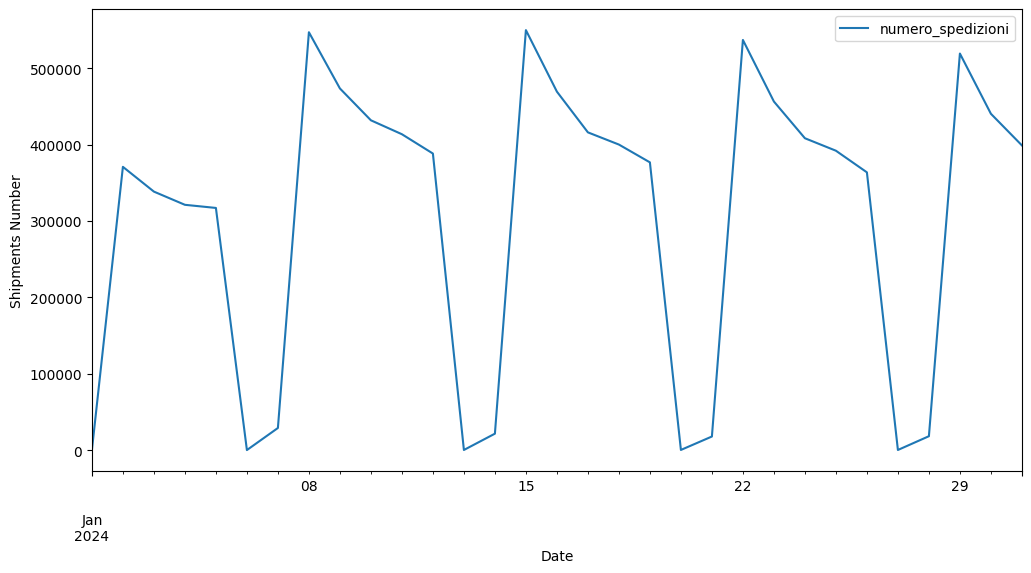

In [70]:
# Display all data
ax = df.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax.set_ylabel('Shipments Number')
ax.set_xlabel('Date')


# Display a data subset to explore weekly patterns
january_2024_data = df[(df['data'].dt.month == 1) & (df['data'].dt.year == 2024)]

ax_3 = january_2024_data.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax_3.set_ylabel('Shipments Number')
ax_3.set_xlabel('Date')

  # Adjust the width as needed
plt.show()

This time series shows peaks in the final months of the year (November, December) and minimums in the months of January (after the holidays) and August.

Focusing on the weekly patterns, we can see that we have a peak of shipments on Mondays, while the number of shipments is very low on weekends and holidays.

For the forecast of a time series like this one, weekly, yearly and holidays patterns needs to be taken in consideration.


#### 3 - Data Preparation

When building a Prophet model, it is mandatory to have a dataset with the
columns ‘ds’ and ‘y’.
This is how the model recognizes the date column (‘ds’) and the dependent variable (‘y’)

In [79]:
df = df.rename(columns={'data': 'ds'})
df = df.rename(columns={'numero_spedizioni': 'y'})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1004 non-null   datetime64[ns]
 1   y       1004 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.8 KB
None


#### 4 - Hyperparameters Tuning

In Prophet, a possibile approach for Hyperparameters Tuning is the Cross Validation.

Cross Validation procedure can be done automatically for a range of historical cutoffs using the *cross_validation* function.
We need to specify the forecast horizon (*horizon*), and then optionally the size of the initial training period (*initial*) and the spacing between cutoff dates (*period*). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of *cross_validation* is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

For this example, we will tune the following hyperparameters:
*   changepoint prior scale
*   seasonality prior scale
*   holidays prior scale
*   yearly seasonality fourier order
*   weekly seasonality fourier order

We will use the rmse (Root Mean Square Error) metric to evaluate results


In [ ]:
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

year_list = df['ds'].dt.year.unique().tolist()
year_list.append(year_list[-1] + 1)
holidays = make_holidays_df(year_list=year_list, country='IT')

param_grid = {
    'changepoint_prior_scale': [0.005, 0.05, 0.5], #Trend Flexibility
    'seasonality_prior_scale': [0.1, 1, 10], # Seasonality Flexibility
    'holidays_prior_scale': [0.1, 1, 10], # Holidays Flexibility
    'seasonality_mode' : ['additive','multiplicative'], # ['multiplicative', 'additive']
    'yearly_seasonality_fourier_order' : [10, 20],
    'weekly_seasonality_fourier_order' : [5, 8]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:

    model = Prophet(
        yearly_seasonality= params['yearly_seasonality_fourier_order']
      , weekly_seasonality= params['weekly_seasonality_fourier_order']
      , changepoint_prior_scale = params['changepoint_prior_scale']
      , seasonality_prior_scale = params['seasonality_prior_scale']
      , holidays_prior_scale = params['holidays_prior_scale']
      , seasonality_mode = params['seasonality_mode']
      , holidays = holidays)

    model.fit(df)
    df_cv = cross_validation(model, initial = '365.25 days', period = '50 days', horizon='100 days') # Initial window of 1 year, shift period of 50 days, forecast horizon of 100 days
    df_p = performance_metrics(df_cv, rolling_window=1)

    result_row = {
        'changepoint_prior_scale': params['changepoint_prior_scale'],
        'seasonality_prior_scale': params['seasonality_prior_scale'],
        'holidays_prior_scale': params['holidays_prior_scale'],
        'seasonality_mode': params['seasonality_mode'],
        'yearly_seasonality_fourier_order': params['yearly_seasonality_fourier_order'],
        'weekly_seasonality_fourier_order': params['weekly_seasonality_fourier_order'],
        'rmse': df_p['rmse'].values[0]
    }

    rmses.append(result_row)

Then, we will find the best combination

In [99]:
# Sort the list of dictionaries based on the 'rmse' key
sorted_rmses = sorted(rmses, key=lambda x: x['rmse'])

# Get the row with the lowest RMSE
best_result = sorted_rmses[0]

print(best_result)

{'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'yearly_seasonality_fourier_order': 20, 'weekly_seasonality_fourier_order': 8, 'rmse': 67268.91225898114}


#### 5 - Forecasting with Prophet

Now that we have found the best combination of parameters, we can fit the Prophet model and retrieve forecast results.

For each forecasted rows, Prophet makes it possible to inspect the values ​​of the components that led the model to calculate that forecast value.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2y3yotm4/2lxjq023.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2y3yotm4/94wbh4pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11817', 'data', 'file=/tmp/tmp2y3yotm4/2lxjq023.json', 'init=/tmp/tmp2y3yotm4/94wbh4pt.json', 'output', 'file=/tmp/tmp2y3yotm4/prophet_modela5fvebgr/prophet_model-20240306135620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,trend,weekly,yearly,holidays,yhat
ds,,,,,
2021-06-01,370031.020068,-0.020357,0.046286,0.000000,379625.750743
2021-06-02,370151.971484,-0.082371,0.050887,-0.929235,14540.270644
2021-06-03,370272.922899,-0.133441,0.054680,0.000000,341110.122293
2021-06-04,370393.874315,-0.204454,0.057365,0.000000,315913.106626
2021-06-05,370514.825730,-0.990242,0.058710,0.000000,25368.722556
...,...,...,...,...,...
2025-02-24,531278.041378,0.113202,-0.056958,0.000000,561159.503127
2025-02-25,531393.585918,-0.020357,-0.052316,0.000000,492775.966630
2025-02-26,531509.130459,-0.082371,-0.046296,0.000000,463121.826918


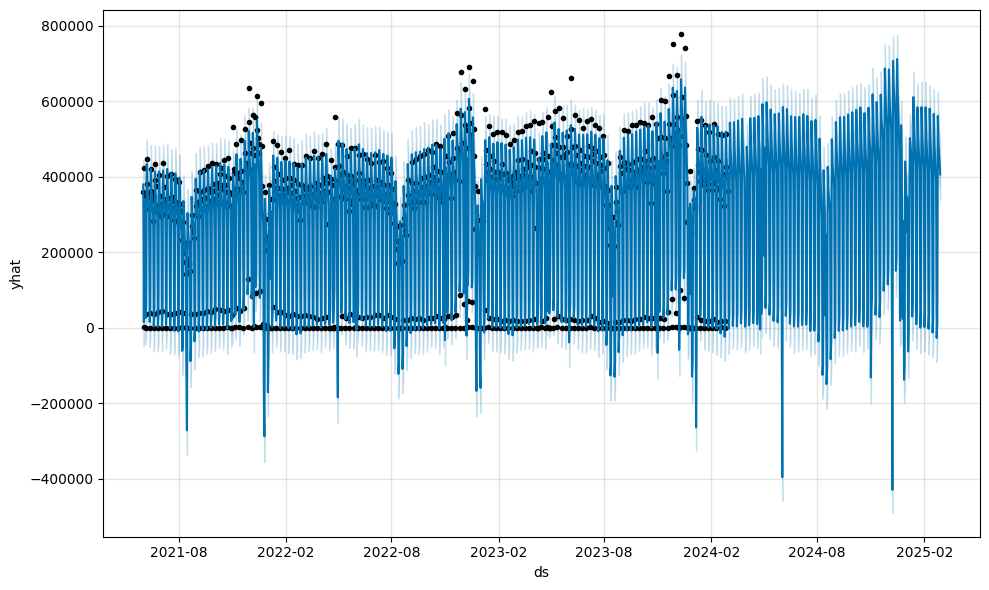

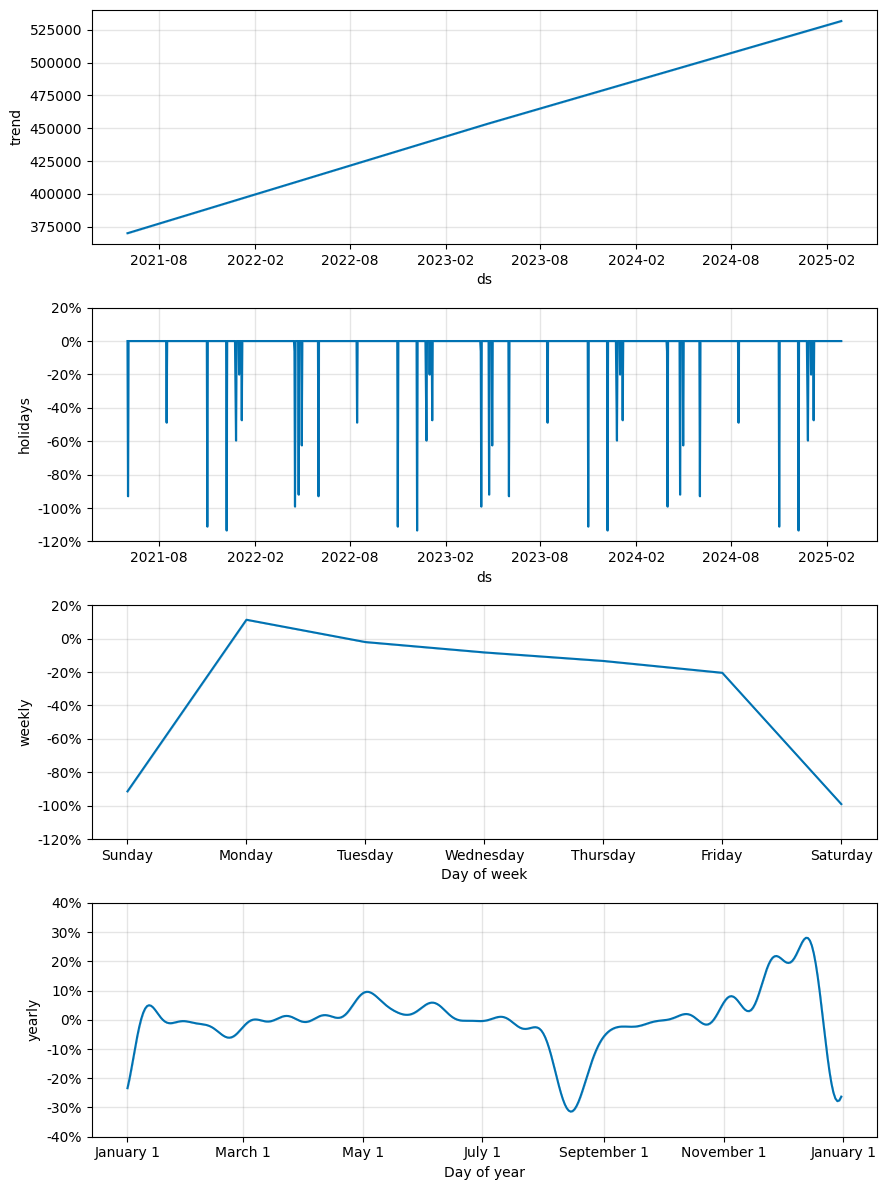

In [112]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

year_list = df['ds'].dt.year.unique().tolist()
year_list.append(year_list[-1] + 1)
holidays = make_holidays_df(year_list=year_list, country='IT')

model = Prophet(
        interval_width=0.85
      , yearly_seasonality= best_result['yearly_seasonality_fourier_order']
      , weekly_seasonality= best_result['weekly_seasonality_fourier_order']
      , changepoint_prior_scale = best_result['changepoint_prior_scale']
      , seasonality_prior_scale = best_result['seasonality_prior_scale']
      , holidays_prior_scale = best_result['holidays_prior_scale']
      , seasonality_mode = best_result['seasonality_mode']
      , holidays = holidays)

model.fit( df )

future_pd = model.make_future_dataframe(
    periods=365,
    freq='D',
    include_history=True
)

forecast_pd = model.predict( future_pd )

f_pd = forecast_pd.set_index('ds')

fig = model.plot(forecast_pd, xlabel='ds',
ylabel=r'yhat')

fig2 = model.plot_components(forecast_pd)
fig2.show()

selected_columns = [ 'trend', 'weekly', 'yearly', 'holidays', 'yhat']
f_pd[selected_columns]